In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
mesh=47
y_val = torch.tensor([147])

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)


        PCa_b   trpnmax    Gncx_b     Tref    perm50    nperm   TRPN_n  \
0    0.000122  0.079681  0.001599  175.127  0.194890  2.76968  2.59449   
1    0.000094  0.089178  0.001334  174.341  0.388696  2.03769  2.94509   
2    0.000128  0.075311  0.001740  179.916  0.245876  2.36111  2.92207   
3    0.000142  0.122175  0.002428  198.270  0.408520  2.86864  2.84040   
4    0.000095  0.110494  0.001329  165.397  0.282575  2.88664  2.31923   
..        ...       ...       ...      ...       ...      ...      ...   
795  0.000093  0.118370  0.001163  184.647  0.283320  2.99653  2.46956   
796  0.000091  0.079472  0.000975  198.891  0.456715  3.01241  2.07730   
797  0.000147  0.087607  0.001378  195.996  0.213886  2.51946  2.80751   
798  0.000151  0.116453  0.001457  192.469  0.372302  2.74916  2.55940   
799  0.000112  0.073569  0.001336  170.032  0.322520  1.91660  2.91944   

           dr     wfrac    TOT_A  ...    AoPref    PaPref     VePref  \
0    0.200250  0.295068  17.5391  ...  

In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_47/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

      LVedv  LVedp  LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0    126.12  14.48  51.71  190.91       1903      -1004  147.49  15.05   
1    130.59  14.97  77.74  181.83       3228      -1233  122.13   9.85   
2    140.46  18.09  67.39   91.30       1718       -817  147.21  22.19   
3    118.50  21.02  46.92  104.71       2466       -914  149.78  18.21   
4    102.87  11.39  49.72  116.54       3174       -942  143.04  15.92   
..      ...    ...    ...     ...        ...        ...     ...    ...   
345  107.52   5.72  59.93  117.05       2749       -996  122.54   6.51   
346  105.98  19.42  51.10  151.84       2576      -1053  161.88  17.49   
347  107.52  11.64  47.46  124.78       2593       -939  137.71  10.34   
348  113.75  13.64  55.39  136.51       2724       -917  152.35  16.90   
349  151.25  17.85  65.86  148.79       2698       -913  150.11  16.02   

      RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0     71.91   65.32  ...   69.47   14

# Emulator

In [5]:
y_all.max()

LVedv         158.530
LVedp          32.430
LVesv          91.260
LVpMax        260.870
LVdpdtMax    4538.000
LVdpdtMin    -351.000
RVedv         191.360
RVedp          33.040
RVesv         105.280
RVpMax         92.390
RVdpdtMax    1218.000
RVdpdtMin    -107.000
LAedv          61.830
LAesv          55.590
LAvMax         81.810
LApMax         32.340
RAedv          68.850
RAesv          58.200
RAvMax         86.220
RApMax         31.790
LAsvA          16.710
LAinflV        22.810
LAsvV          22.880
RAsvA          21.880
RAinflV        20.390
RAsvV          21.400
A_TAT         166.789
V_TAT         110.775
dtype: float64

In [6]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

input_masked=input_masked.iloc[np.array(mask==1),]

In [7]:
input_masked

PCa_b   trpnmax    Gncx_b     Tref    perm50    nperm   TRPN_n  \
2    0.000128  0.075311  0.001740  179.916  0.245876  2.36111  2.92207   
3    0.000142  0.122175  0.002428  198.270  0.408520  2.86864  2.84040   
6    0.000126  0.108006  0.001234  183.942  0.386847  2.74360  2.80531   
7    0.000141  0.101289  0.001261  191.848  0.379215  2.71667  2.75931   
12   0.000150  0.092182  0.001304  161.633  0.177513  2.41762  2.98397   
..        ...       ...       ...      ...       ...      ...      ...   
591  0.000100  0.085765  0.001271  178.687  0.339663  2.68286  2.77456   
592  0.000129  0.080461  0.001478  198.970  0.359955  2.40626  2.41078   
594  0.000143  0.099208  0.001737  169.327  0.215242  2.76542  2.85959   
596  0.000145  0.101178  0.001522  191.967  0.452761  2.95329  2.72150   
599  0.000097  0.090588  0.001293  196.703  0.290233  2.99059  2.44680   

           dr     wfrac    TOT_A  ...    AoPref   PaPref    VePref      kArt  \
2    0.178430  0.363202  26.0661  ...  131.4830  39.3790   8.96592   5.39047   
3    0.307598  0.708652  20.4240  ...  137.4090  60.3757  22.24320  10.80210   
6    0.324396  0.473581  33.0962  ...   82.2075  60.4809  18.61070   5.23605   
7    0.274772  0.575894  26.7925  ...  105.1700  66.7100  16.43940   6.88459   
12   0.185483  0.573994  21.6849  ...  120.4910  24.4867   9.23900   6.04995   
..        ...       ...      ...  ...       ...      ...       ...       ...   
591  0.327427  0.486252  24.2330  ...  117.2290  36.5437   3.74457   8.83894   
592  0.220000  0.296064  34.8676  ...  149.4450  74.9226  18.24690   6.60390   
594  0.196096  0.440477  17.3650  ...   90.8783  69.4994   5.98910   8.60742   
596  0.264294  0.541003  14.0653  ...  156.3550  11.3118   9.20760   5.14089   
599  0.268814  0.493442  19.7608  ...  124.0160  60.3654  23.50280   5.33176   

     a_ventricles  a_atria    k_peri  Tref_lvrv    EDP_lv   EDP_rv  
2         2.28376  1.69743  0.002596   0.932621  14.58400  6.56783  
3         2.96033  5.82476  0.020070   0.995065  14.09110  6.32621  
6         2.85366  4.59552  0.027404   0.901970   9.03667  7.22786  
7         3.95044  5.51921  0.004023   0.669942  24.31300  4.79645  
12        3.95538  5.39593  0.012989   0.760287  23.99770  5.51574  
..            ...      ...       ...        ...       ...      ...  
591       3.53106  4.90403  0.020008   0.509667  16.66440  5.16436  
592       1.25871  3.75065  0.043767   0.781569  19.82970  4.29037  
594       1.75329  3.43187  0.021310   0.705990  16.95520  5.75320  
596       1.83938  5.55451  0.028785   0.544923  13.42180  6.01778  
599       1.01144  4.31835  0.025798   0.880465   8.37679  5.42642  

[350 rows x 46 columns]

In [8]:
y_all

LVedv  LVedp  LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0    126.12  14.48  51.71  190.91       1903      -1004  147.49  15.05   
1    130.59  14.97  77.74  181.83       3228      -1233  122.13   9.85   
2    140.46  18.09  67.39   91.30       1718       -817  147.21  22.19   
3    118.50  21.02  46.92  104.71       2466       -914  149.78  18.21   
4    102.87  11.39  49.72  116.54       3174       -942  143.04  15.92   
..      ...    ...    ...     ...        ...        ...     ...    ...   
345  107.52   5.72  59.93  117.05       2749       -996  122.54   6.51   
346  105.98  19.42  51.10  151.84       2576      -1053  161.88  17.49   
347  107.52  11.64  47.46  124.78       2593       -939  137.71  10.34   
348  113.75  13.64  55.39  136.51       2724       -917  152.35  16.90   
349  151.25  17.85  65.86  148.79       2698       -913  150.11  16.02   

      RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0     71.91   65.32  ...   69.47   14.85  13.41     9.87   9.93  18.94   
1     67.22   49.67  ...   64.42    9.55   5.80     7.82   7.74   6.11   
2     73.38   50.45  ...   70.21   21.87   3.91    16.72  16.66   5.73   
3     73.46   49.76  ...   68.95   17.76   6.05     9.89   9.64   7.54   
4     75.00   43.76  ...   68.49   15.43   4.63     8.17   7.70   7.34   
..      ...     ...  ...     ...     ...    ...      ...    ...    ...   
345   79.56   32.51  ...   64.22    6.73   3.72     6.96   7.12   5.57   
346  105.28   68.08  ...   69.91   17.39   4.36    10.91  10.90   5.97   
347   76.13   52.37  ...   67.04    9.94   8.06     9.22   9.15  10.60   
348   81.61   44.54  ...   67.10   15.85   4.58    10.88  10.69   7.34   
349   62.23   52.69  ...   69.38   15.10  11.39    17.39  17.35  12.41   

     RAinflV  RAsvV    A_TAT     V_TAT  
0       8.75  11.33  126.700   90.6829  
1       8.20   8.68  131.971   90.2363  
2       9.97  10.19  150.992  106.3080  
3       7.62   9.35  121.213   93.5512  
4       7.89   9.48  150.880   88.6315  
..       ...    ...      ...       ...  
345     6.97   6.85  136.393   91.2685  
346     8.83   8.79  141.936   99.3900  
347     8.78   9.39  150.650  102.5370  
348     7.84   8.12  161.930   90.7375  
349    12.13  12.41  148.578  106.5630  

[350 rows x 28 columns]

In [9]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

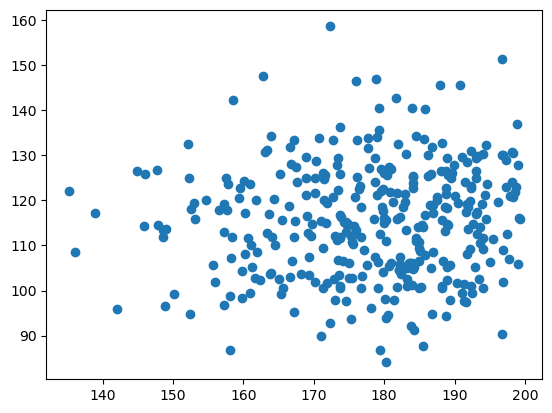

In [10]:
plt.plot(x_train[:,3],y_train[:,0],'o')

In [11]:
np.linspace(50,300,11).shape

(11,)

In [13]:
X=x_train
y=y_train
x_train2, x_test, y_train2, y_test = train_test_split(
    X,
    y,
    test_size=45,
    random_state=seed
)

In [40]:
reps= 5
p = np.linspace(50,300,11)
R2 = torch.zeros(28,p.shape[0])
MSE = torch.zeros(28,p.shape[0])
ISE = torch.zeros(28,p.shape[0])
for i in range(reps):  
    X=x_train
    y=y_train
    x_train2, x_test, y_train2, y_test = train_test_split(
        X,
        y,
        test_size=45,
        random_state=seed+i
    )
    for j,pn in enumerate(p):

        X=x_train2
        y=y_train2
        x_train3, x_test1, y_train3, y_test1 = train_test_split(
            X,
            y,
            train_size=int(pn),
            random_state=seed+i
        )
        emulator = GPE.ensemble(x_train3,y_train3,mean_func="linear",training_iter=500);
        R2[:,j]+=emulator.R2(x_test,y_test)/reps
        MSE[:,j]+=emulator.MSE(x_test,y_test)/reps
        ISE[:,j]+=emulator.ISE(x_test,y_test)/reps
        print(R2[:,j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([-0.5580, -2.1890, -0.1154, -1.6975, -1.0892, -1.2781, -0.8969, -1.0108,
        -0.1521, -0.0639, -0.0735, -0.6393, -0.3808, -0.4167, -0.3415, -2.0855,
        -0.3503, -0.3356, -0.4452, -1.0438, -0.2209, -0.5180, -0.6114, -0.2932,
        -0.3310, -0.2062,  0.1860,  0.1825], grad_fn=<SelectBackward0>)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([ 0.1086,  0.0370,  0.1557,  0.0204, -0.0458,  0.0041,  0.0552,  0.0810,
         0.1231,  0.1640,  0.1081,  0.1494,  0.0981,  0.1074,  0.1279,  0.0556,
         0.0371,  0.1203,  0.0546,  0.0820,  0.1146,  0.0916,  0.0518,  0.0790,
         0.0717,  0.0865,  0.1924,  0.1906], grad_fn=<SelectBackward0>)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([0.1480, 0.1082, 0.1681, 0.1013, 0.0551, 0.0713, 0.1036, 0.1214, 0.1396,
        0.1737, 0.1371, 0.0157, 0.1466, 0.1425, 0.1593, 0.1104, 0.1089, 0.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([ 0.3570,  0.1984,  0.4411,  0.1221,  0.0896,  0.0265,  0.1841,  0.2124,
         0.3509,  0.4523,  0.3549, -1.1043,  0.3185,  0.2838,  0.3704,  0.2312,
        -0.0927,  0.2105, -0.0379,  0.2276,  0.2772,  0.2615,  0.2155,  0.3461,
         0.1797,  0.2519,  0.5828,  0.5740], grad_fn=<SelectBackward0>)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([0.4459, 0.3163, 0.4981, 0.3175, 0.2571, 0.2422, 0.3528, 0.3661, 0.4515,
        0.5054, 0.4311, 0.0768, 0.3960, 0.4542, 0.4562, 0.3193, 0.2820, 0.4344,
        0.3555, 0.3619, 0.3430, 0.3942, 0.3574, 0.3936, 0.3934, 0.3983, 0.5849,
        0.5798], grad_fn=<SelectBackward0>)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([0.4591, 0.3658, 0.5239, 0.3782, 0.3396, 0.3739, 0.3994, 0.4129, 0.4734,
        0.5056, 0.4649, 0.2180, 0.4477, 0.4553, 0.4815, 0.3712, 0.3817, 0.4451,
        0.4066, 0.4122, 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([0.7457, 0.4904, 0.8520, 0.5598, 0.5128, 0.4912, 0.5875, 0.5833, 0.7684,
        0.8237, 0.6848, 0.2440, 0.6563, 0.7009, 0.7315, 0.4986, 0.4961, 0.6900,
        0.6176, 0.5859, 0.5803, 0.6038, 0.5388, 0.6440, 0.6661, 0.6825, 0.9782,
        0.9656], grad_fn=<SelectBackward0>)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([0.7735, 0.6151, 0.8793, 0.6568, 0.6038, 0.6540, 0.6342, 0.6409, 0.8001,
        0.8296, 0.7088, 0.3786, 0.7481, 0.7307, 0.7596, 0.6211, 0.5860, 0.7114,
        0.6683, 0.6468, 0.6420, 0.6132, 0.5806, 0.6672, 0.7069, 0.7240, 0.9821,
        0.9745], grad_fn=<SelectBackward0>)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
tensor([0.8066, 0.6198, 0.8879, 0.7082, 0.6686, 0.7048, 0.6487, 0.6501, 0.7972,
        0.8396, 0.7278, 0.4324, 0.7747, 0.7557, 0.7782, 0.6308, 0.6208, 0.7106,
        0.6691, 0.6543, 0.6607, 0.6533, 0.6528, 0.70

In [41]:
y_labels

0
0       LVedv
1       LVedp
2       LVesv
3      LVpMax
4   LVdpdtMax
5   LVdpdtMin
6       RVedv
7       RVedp
8       RVesv
9      RVpMax
10  RVdpdtMax
11  RVdpdtMin
12      LAedv
13      LAesv
14     LAvMax
15     LApMax
16      RAedv
17      RAesv
18     RAvMax
19     RApMax
20      LAsvA
21    LAinflV
22      LAsvV
23      RAsvA
24    RAinflV
25      RAsvV
26      A_TAT
27      V_TAT

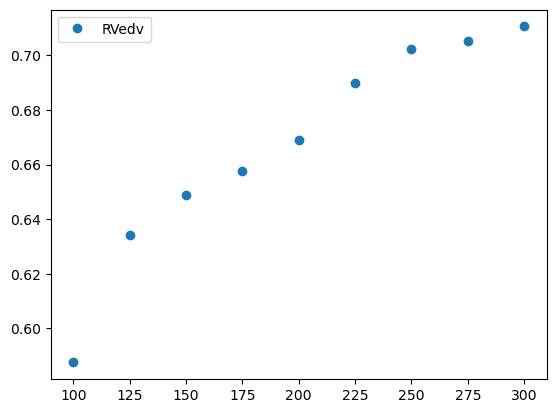

In [42]:
lev=6
plt.plot(p[2:,],R2.detach().numpy().T[2:,lev],'o')
plt.legend(y_labels.values[lev])

Text(0.5, 0, 'Training points')

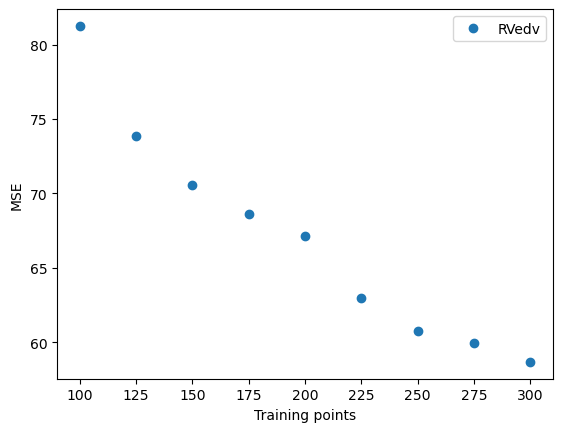

In [56]:
lev=6
plt.plot(p[2:,],MSE.detach().numpy().T[2:,lev],'o')
plt.legend(y_labels.values[lev])
plt.ylabel('MSE')
plt.xlabel('Training points')

In [60]:
y_train[:,lev]

tensor([147.4900, 122.1300, 147.2100, 149.7800, 143.0400, 164.3400, 128.1200,
        127.1600, 145.9800, 142.7500, 113.5400, 151.4700, 140.5500, 162.8500,
        146.2300, 144.7800, 188.4200, 127.3900, 126.7000, 132.4500, 132.8600,
        133.4500, 174.7200, 133.7500, 125.6900, 119.0400, 127.8100, 127.6900,
        103.1200, 128.0700, 116.0600, 154.6000, 140.9900, 163.7700, 140.9200,
        126.5100, 122.1300, 152.0100, 120.0900, 139.7500, 154.6600, 139.2300,
        129.7000, 133.0300, 135.9000, 152.7800, 160.0000, 125.7400, 136.6100,
        140.9500, 143.7600, 111.8600, 147.8600, 128.0700, 118.1200, 142.5500,
        155.8200, 140.9400, 123.0400, 121.6500, 135.7400, 134.7600, 116.1000,
        133.7100, 153.9100, 155.5800, 156.1200, 132.1400, 134.0100, 153.7800,
        144.3800, 143.5600, 127.8400, 108.5900, 126.1000, 161.5500, 143.1600,
        135.9700, 124.6200, 132.2300, 134.6700, 145.2500, 119.4300, 124.2100,
        134.2400, 148.9300, 113.4800, 148.9000, 145.6100, 168.62

Text(0.5, 0, 'Training points')

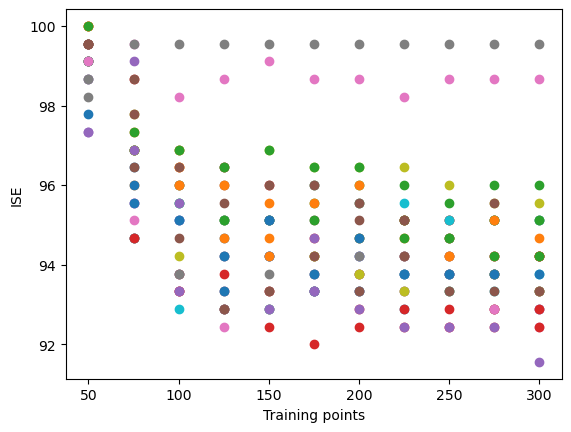

In [55]:
lev=6
plt.plot(p[:,],ISE.detach().numpy().T[:,],'o');
plt.ylabel('ISE')
plt.xlabel('Training points')

In [61]:
R2np=R2.detach().numpy()

In [62]:
R2diff=np.diff(R2np,axis=1)

Text(0.5, 0, 'training points')

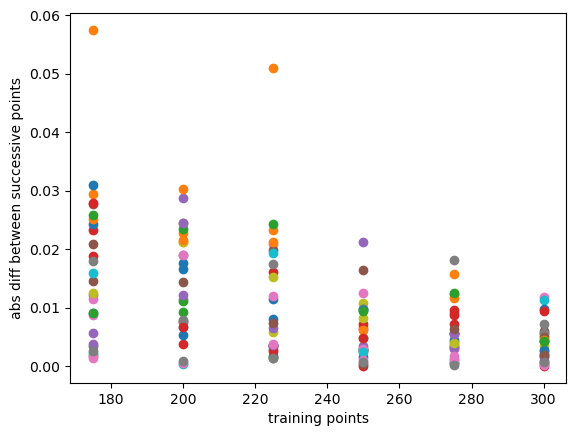

In [65]:
lev=6
plt.plot(p[5:,],np.abs(R2diff.T[4:,]),'o')
#plt.legend(y_labels.values[lev])
plt.ylabel('abs diff between successive points')
plt.xlabel('training points')

In [109]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [312]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[5.83464e-05, 0.000154081]
[0.0658425, 0.122952]
[0.000921633, 0.00242766]
[135.206, 199.267]
[0.175616, 0.492279]
[1.72479, 3.03954]
[1.86623, 2.9983]
[0.125877, 0.35794]
[0.262072, 0.747163]
[12.6117, 37.1001]
[0.0125385, 0.0313515]
[0.411652, 0.959688]
[1.52985, 4.46122]
[0.00298249, 0.00748154]
[0.0376784, 0.104365]
[0.0836606, 0.184816]
[50.5061, 149.361]
[0.180935, 0.513914]
[2.56928, 7.39353]
[1.04489, 2.97164]
[0.126018, 0.372123]
[0.25082, 0.747605]
[12.6298, 37.4525]
[1.12081, 3.31601]
[0.472081, 1.28794]
[4.54655, 13.481]
[0.675114, 0.836114]
[0.470936, 0.644341]
[100, 200]
[0.119323, 4.99241]
[0.180614, 4.98004]
[254.56, 1499.78]
[256.976, 1497.04]
[151.853, 997.867]
[151.778, 990.442]
[150.165, 994.975]
[57.4508, 159.391]
[4.06892, 78.9918]
[0.521288, 23.9351]
[4.05338, 11.9518]
[0.75574, 4.99176]
[1.53412, 5.99971]
[0.000551476, 0.0495423]
[0.505053, 0.998839]
[8.14077, 27.9295]
[4.11977, 7.69434]


In [111]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_4686/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [112]:
data1.shape

torch.Size([96256, 46])

In [113]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                           ST   ST_conf
(PCa_b,)             0.001764  0.000166
(trpnmax,)           0.000824  0.000073
(Gncx_b,)            0.001200  0.000103
(Tref,)              0.000483  0.000051
(perm50,)            0.000104  0.000009
(nperm,)             0.000080  0.000007
(TRPN_n,)            0.003043  0.000256
(dr,)                0.003569  0.000339
(wfrac,)             0.000553  0.000054
(TOT_A,)             0.000667  0.000068
(ktm_unblock,)       0.000586  0.000050
(ca50,)              0.000488  0.000042
(mu,)                0.001084  0.000096
(maxI_up,)           0.000654  0.000058
(maxTrpn,)           0.005071  0.000463
(g_CaL,)             0.004937  0.000474
(Tref,)              0.001612  0.000146
(perm50,)            0.005909  0.000554
(nperm,)             0.000963  0.000082
(TRPN_n,)            0.008591  0.000775
(dr,)                0.002198  0.000190
(wfrac,)             0.000231  0.000021
(TOT_A,)             0.001845  0.000177
(phi,)               0.000034  0.000003


                               ST       ST_conf
(PCa_b,)             2.058536e-02  1.874061e-03
(trpnmax,)           1.072139e-02  8.889305e-04
(Gncx_b,)            5.286603e-02  4.715162e-03
(Tref,)              1.943269e-02  1.769207e-03
(perm50,)            2.636305e-02  2.104708e-03
(nperm,)             8.982499e-04  7.709217e-05
(TRPN_n,)            6.535544e-04  6.368911e-05
(dr,)                6.122999e-02  5.724994e-03
(wfrac,)             6.780274e-03  6.559647e-04
(TOT_A,)             2.157021e-02  2.034829e-03
(ktm_unblock,)       3.004872e-02  2.859747e-03
(ca50,)              2.519793e-02  2.243049e-03
(mu,)                2.908097e-02  2.370368e-03
(maxI_up,)           2.751257e-05  2.342834e-06
(maxTrpn,)           2.617562e-04  2.364349e-05
(g_CaL,)             7.045892e-04  5.946835e-05
(Tref,)              3.674301e-03  2.655664e-04
(perm50,)            8.188247e-05  7.338313e-06
(nperm,)             1.368645e-03  1.155357e-04
(TRPN_n,)            4.591201e-03  4.246

                           ST   ST_conf
(PCa_b,)             0.001527  0.000135
(trpnmax,)           0.004980  0.000479
(Gncx_b,)            0.012452  0.001195
(Tref,)              0.000520  0.000052
(perm50,)            0.005774  0.000624
(nperm,)             0.000063  0.000006
(TRPN_n,)            0.000798  0.000078
(dr,)                0.000992  0.000091
(wfrac,)             0.002948  0.000257
(TOT_A,)             0.000443  0.000040
(ktm_unblock,)       0.000566  0.000053
(ca50,)              0.000275  0.000026
(mu,)                0.002200  0.000175
(maxI_up,)           0.000891  0.000091
(maxTrpn,)           0.013529  0.001243
(g_CaL,)             0.005531  0.000565
(Tref,)              0.000151  0.000013
(perm50,)            0.001160  0.000106
(nperm,)             0.001755  0.000164
(TRPN_n,)            0.001282  0.000117
(dr,)                0.001814  0.000159
(wfrac,)             0.000125  0.000014
(TOT_A,)             0.001598  0.000155
(phi,)               0.000026  0.000002


                               ST       ST_conf
(PCa_b,)             1.051182e-02  9.560259e-04
(trpnmax,)           5.015005e-03  4.656693e-04
(Gncx_b,)            2.722606e-02  2.866048e-03
(Tref,)              9.919647e-03  9.191229e-04
(perm50,)            1.553042e-02  1.528087e-03
(nperm,)             3.382455e-05  2.929327e-06
(TRPN_n,)            6.131332e-04  5.251741e-05
(dr,)                5.521797e-02  5.126511e-03
(wfrac,)             1.559590e-03  1.463940e-04
(TOT_A,)             3.034049e-02  2.884202e-03
(ktm_unblock,)       1.089875e-02  9.899009e-04
(ca50,)              1.559282e-02  1.662906e-03
(mu,)                2.037217e-02  1.980641e-03
(maxI_up,)           3.807685e-04  3.718294e-05
(maxTrpn,)           1.256692e-03  1.243824e-04
(g_CaL,)             2.732093e-06  2.689789e-07
(Tref,)              1.303329e-04  1.278687e-05
(perm50,)            2.724710e-06  2.815967e-07
(nperm,)             4.224292e-04  4.675642e-05
(TRPN_n,)            1.542070e-04  1.479

                           ST   ST_conf
(PCa_b,)             0.001757  0.000157
(trpnmax,)           0.076091  0.006636
(Gncx_b,)            0.004580  0.000453
(Tref,)              0.067701  0.006635
(perm50,)            0.000924  0.000085
(nperm,)             0.027172  0.002749
(TRPN_n,)            0.084361  0.007697
(dr,)                0.050069  0.004386
(wfrac,)             0.004575  0.000460
(TOT_A,)             0.000157  0.000015
(ktm_unblock,)       0.030895  0.002666
(ca50,)              0.013117  0.001522
(mu,)                0.022408  0.002159
(maxI_up,)           0.001108  0.000107
(maxTrpn,)           0.000195  0.000018
(g_CaL,)             0.003978  0.000407
(Tref,)              0.004236  0.000447
(perm50,)            0.005159  0.000522
(nperm,)             0.000946  0.000083
(TRPN_n,)            0.002274  0.000224
(dr,)                0.000044  0.000004
(wfrac,)             0.000841  0.000082
(TOT_A,)             0.000979  0.000084
(phi,)               0.000222  0.000021


                               ST       ST_conf
(PCa_b,)             1.412684e-03  1.339731e-04
(trpnmax,)           6.886819e-05  5.067303e-06
(Gncx_b,)            4.538460e-03  3.649106e-04
(Tref,)              2.559072e-04  2.506041e-05
(perm50,)            1.875383e-03  1.837903e-04
(nperm,)             1.924382e-04  1.787174e-05
(TRPN_n,)            2.213793e-06  1.990827e-07
(dr,)                1.039702e-05  8.374646e-07
(wfrac,)             6.537905e-04  6.523951e-05
(TOT_A,)             2.257275e-07  1.846622e-08
(ktm_unblock,)       3.457955e-04  2.915308e-05
(ca50,)              2.199950e-03  2.103096e-04
(mu,)                2.406306e-05  2.063033e-06
(maxI_up,)           7.624470e-03  6.535395e-04
(maxTrpn,)           8.977478e-02  8.409359e-03
(g_CaL,)             1.574265e-01  1.358895e-02
(Tref,)              2.779952e-02  2.393427e-03
(perm50,)            1.549837e-01  1.518887e-02
(nperm,)             4.463943e-03  4.157185e-04
(TRPN_n,)            3.635401e-02  3.108

                               ST       ST_conf
(PCa_b,)             1.104441e-02  9.590993e-04
(trpnmax,)           3.460961e-03  3.172224e-04
(Gncx_b,)            2.195900e-02  1.928090e-03
(Tref,)              2.469710e-04  2.397456e-05
(perm50,)            1.594443e-02  1.627964e-03
(nperm,)             9.157115e-06  8.340445e-07
(TRPN_n,)            2.220661e-04  2.188662e-05
(dr,)                1.946170e-05  1.673200e-06
(wfrac,)             2.297807e-05  1.937985e-06
(TOT_A,)             2.095832e-07  1.722135e-08
(ktm_unblock,)       7.183156e-04  7.028659e-05
(ca50,)              1.172628e-02  9.939948e-04
(mu,)                6.816202e-05  6.206773e-06
(maxI_up,)           6.351541e-04  5.513271e-05
(maxTrpn,)           4.076393e-06  3.519135e-07
(g_CaL,)             8.591358e-04  7.487526e-05
(Tref,)              6.759872e-05  5.659407e-06
(perm50,)            1.327384e-04  1.321457e-05
(nperm,)             4.128479e-04  3.391596e-05
(TRPN_n,)            5.346966e-04  5.005

                               ST       ST_conf
(PCa_b,)             1.716493e-03  1.656320e-04
(trpnmax,)           1.133021e-04  9.174829e-06
(Gncx_b,)            6.240292e-03  5.009531e-04
(Tref,)              7.200217e-05  6.380224e-06
(perm50,)            3.990934e-03  3.121528e-04
(nperm,)             2.668940e-04  2.194732e-05
(TRPN_n,)            1.848971e-05  1.643169e-06
(dr,)                4.464973e-04  4.193730e-05
(wfrac,)             1.635907e-07  1.522611e-08
(TOT_A,)             2.183320e-05  2.023297e-06
(ktm_unblock,)       6.186182e-07  5.674295e-08
(ca50,)              6.071512e-03  5.464409e-04
(mu,)                1.636741e-04  1.373793e-05
(maxI_up,)           1.227816e-02  1.082705e-03
(maxTrpn,)           1.054296e-01  9.409193e-03
(g_CaL,)             1.706567e-01  1.513031e-02
(Tref,)              3.688425e-02  2.871263e-03
(perm50,)            1.765696e-01  1.681235e-02
(nperm,)             5.245259e-03  5.007368e-04
(TRPN_n,)            4.891482e-02  4.566

                               ST       ST_conf
(PCa_b,)             4.351402e-04  3.782695e-05
(trpnmax,)           8.588160e-05  7.001952e-06
(Gncx_b,)            4.292258e-05  4.166819e-06
(Tref,)              2.252512e-04  1.881499e-05
(perm50,)            8.515880e-04  8.056733e-05
(nperm,)             3.534316e-04  3.541548e-05
(TRPN_n,)            1.099165e-04  1.036286e-05
(dr,)                2.444656e-03  2.123496e-04
(wfrac,)             3.661596e-05  3.536871e-06
(TOT_A,)             4.176096e-04  3.668090e-05
(ktm_unblock,)       7.920408e-06  8.102593e-07
(ca50,)              1.291275e-03  1.115032e-04
(mu,)                7.772412e-10  7.791256e-11
(maxI_up,)           9.950229e-03  9.672912e-04
(maxTrpn,)           1.060035e-01  1.096056e-02
(g_CaL,)             1.819517e-01  1.542044e-02
(Tref,)              3.880131e-02  3.695491e-03
(perm50,)            1.733345e-01  1.347297e-02
(nperm,)             7.524233e-03  6.952172e-04
(TRPN_n,)            5.306387e-02  4.308

                               ST       ST_conf
(PCa_b,)             3.716773e-02  3.284946e-03
(trpnmax,)           2.837548e-02  2.553021e-03
(Gncx_b,)            3.146297e-02  2.992758e-03
(Tref,)              1.894590e-02  1.692354e-03
(perm50,)            5.428954e-02  4.525415e-03
(nperm,)             8.509560e-03  7.946016e-04
(TRPN_n,)            1.536713e-04  1.374208e-05
(dr,)                1.177050e-02  1.160289e-03
(wfrac,)             2.749053e-03  2.255085e-04
(TOT_A,)             2.312499e-03  2.100519e-04
(ktm_unblock,)       2.357157e-04  2.258675e-05
(ca50,)              5.165848e-02  4.742311e-03
(mu,)                1.019352e-03  8.838583e-05
(maxI_up,)           5.513093e-07  4.992906e-08
(maxTrpn,)           4.035431e-04  3.316205e-05
(g_CaL,)             6.396899e-03  5.799635e-04
(Tref,)              2.919171e-03  2.537118e-04
(perm50,)            1.727708e-02  1.467303e-03
(nperm,)             6.303199e-04  5.406140e-05
(TRPN_n,)            6.431109e-03  5.435

                           ST       ST_conf
(PCa_b,)             0.074118  6.475386e-03
(trpnmax,)           0.009619  9.051780e-04
(Gncx_b,)            0.052433  4.787445e-03
(Tref,)              0.017186  1.482637e-03
(perm50,)            0.082010  6.949695e-03
(nperm,)             0.002100  2.013328e-04
(TRPN_n,)            0.000519  4.869330e-05
(dr,)                0.002591  2.621010e-04
(wfrac,)             0.000007  5.734959e-07
(TOT_A,)             0.000008  7.350744e-07
(ktm_unblock,)       0.000665  5.626433e-05
(ca50,)              0.101849  8.603766e-03
(mu,)                0.000452  4.042621e-05
(maxI_up,)           0.001475  1.279442e-04
(maxTrpn,)           0.000330  2.768487e-05
(g_CaL,)             0.004709  4.747423e-04
(Tref,)              0.003844  3.950452e-04
(perm50,)            0.011307  9.377553e-04
(nperm,)             0.001361  1.385155e-04
(TRPN_n,)            0.010048  9.004346e-04
(dr,)                0.003293  2.762782e-04
(wfrac,)             0.000112  1

                               ST       ST_conf
(PCa_b,)             2.520769e-06  2.022588e-07
(trpnmax,)           8.743276e-05  6.937523e-06
(Gncx_b,)            6.399718e-08  4.934166e-09
(Tref,)              3.116903e-04  2.642398e-05
(perm50,)            5.181797e-05  4.587768e-06
(nperm,)             1.827341e-05  1.680232e-06
(TRPN_n,)            1.411613e-04  1.336730e-05
(dr,)                7.276549e-05  6.697328e-06
(wfrac,)             9.403194e-05  8.586409e-06
(TOT_A,)             9.053060e-05  7.896480e-06
(ktm_unblock,)       8.536578e-05  7.271890e-06
(ca50,)              5.704445e-08  4.875932e-09
(mu,)                9.437871e-05  8.622358e-06
(maxI_up,)           7.567408e-06  6.806715e-07
(maxTrpn,)           1.938748e-05  1.504127e-06
(g_CaL,)             5.307152e-07  4.589213e-08
(Tref,)              2.733040e-05  2.406965e-06
(perm50,)            1.222811e-06  1.034563e-07
(nperm,)             3.018438e-05  2.688635e-06
(TRPN_n,)            5.936014e-07  5.046

In [114]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [115]:
x_labels.values.squeeze().tolist()

['PCa_b',
 'trpnmax',
 'Gncx_b',
 'Tref',
 'perm50',
 'nperm',
 'TRPN_n',
 'dr',
 'wfrac',
 'TOT_A',
 'ktm_unblock',
 'ca50',
 'mu',
 'maxI_up',
 'maxTrpn',
 'g_CaL',
 'Tref',
 'perm50',
 'nperm',
 'TRPN_n',
 'dr',
 'wfrac',
 'TOT_A',
 'phi',
 'ca50',
 'mu',
 'CV_ventricles',
 'CV_atria',
 'AV_delay',
 'Rsys',
 'Rpulm',
 'mitral_area',
 'tricuspid_area',
 'aortic_area',
 'sysOrifice_area',
 'pulmOrifice_area',
 'AoPref',
 'PaPref',
 'VePref',
 'kArt',
 'a_ventricles',
 'a_atria',
 'k_peri',
 'Tref_lvrv',
 'EDP_lv',
 'EDP_rv']

In [116]:
y_all.columns.tolist()

['LVedv',
 'LVedp',
 'LVesv',
 'LVpMax',
 'LVdpdtMax',
 'LVdpdtMin',
 'RVedv',
 'RVedp',
 'RVesv',
 'RVpMax',
 'RVdpdtMax',
 'RVdpdtMin',
 'LAedv',
 'LAesv',
 'LAvMax',
 'LApMax',
 'RAedv',
 'RAesv',
 'RAvMax',
 'RApMax',
 'LAsvA',
 'LAinflV',
 'LAsvV',
 'RAsvA',
 'RAinflV',
 'RAsvV',
 'A_TAT',
 'V_TAT']

In [117]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

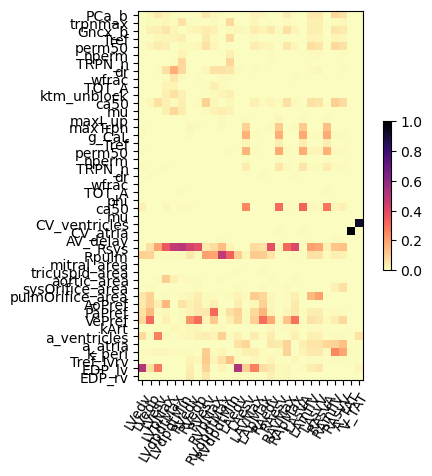

In [118]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first,cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

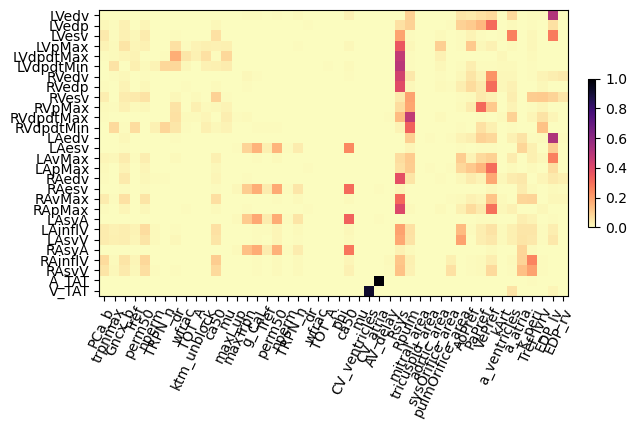

In [392]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[:,],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [209]:
ref=np.argsort(Si_total[:,3])[::-1].tolist()
tot = np.sum(Si_total[:,3])
sens = Si_total[ref,3]

In [211]:
sens

array([3.57617135e-01, 1.11775671e-01, 1.01082342e-01, 6.12299920e-02,
       5.28660256e-02, 3.00487170e-02, 2.90809727e-02, 2.63630521e-02,
       2.51979309e-02, 2.36952047e-02, 2.15702092e-02, 2.05853582e-02,
       1.94326882e-02, 1.41395412e-02, 1.40273544e-02, 1.26158439e-02,
       1.17818323e-02, 1.10279283e-02, 1.07213885e-02, 6.78027444e-03,
       5.51137988e-03, 4.59120076e-03, 3.67430135e-03, 2.62813812e-03,
       2.56150766e-03, 2.47471198e-03, 2.13834328e-03, 1.40907398e-03,
       1.36864470e-03, 1.24448137e-03, 8.98249864e-04, 7.60936703e-04,
       7.04589166e-04, 6.53554433e-04, 5.96661134e-04, 4.49203308e-04,
       4.14198537e-04, 3.50059718e-04, 3.23592987e-04, 2.61756228e-04,
       1.49038502e-04, 1.10023174e-04, 8.18824681e-05, 2.75125740e-05,
       4.03616989e-06, 6.55035533e-07])

In [212]:
np.sum(sens[0:15])

0.9087121944960626

In [213]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [214]:
boundsMaxMin

array([[5.83464e-05, 1.54081e-04],
       [6.58425e-02, 1.22952e-01],
       [9.21633e-04, 2.42766e-03],
       [1.35206e+02, 1.99267e+02],
       [1.75616e-01, 4.92279e-01],
       [1.72479e+00, 3.03954e+00],
       [1.86623e+00, 2.99830e+00],
       [1.25877e-01, 3.57940e-01],
       [2.62072e-01, 7.47163e-01],
       [1.26117e+01, 3.71001e+01],
       [1.25385e-02, 3.13515e-02],
       [4.11652e-01, 9.59688e-01],
       [1.52985e+00, 4.46122e+00],
       [2.98249e-03, 7.48154e-03],
       [3.76784e-02, 1.04365e-01],
       [8.36606e-02, 1.84816e-01],
       [5.05061e+01, 1.49361e+02],
       [1.80935e-01, 5.13914e-01],
       [2.56928e+00, 7.39353e+00],
       [1.04489e+00, 2.97164e+00],
       [1.26018e-01, 3.72123e-01],
       [2.50820e-01, 7.47605e-01],
       [1.26298e+01, 3.74525e+01],
       [1.12081e+00, 3.31601e+00],
       [4.72081e-01, 1.28794e+00],
       [4.54655e+00, 1.34810e+01],
       [6.75114e-01, 8.36114e-01],
       [4.70936e-01, 6.44341e-01],
       [1.00000e+02,

In [215]:
centre[[1,2,4,5,]]

array([9.4397250e-02, 1.6746465e-03, 3.3394750e-01, 2.3821650e+00])

In [216]:
boundsMaxMin=np.array(boundsMaxMin)

In [313]:
boundsMaxMinOrig=np.array(boundsMaxMin)

In [314]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [315]:
def log_likelihood(x,emulator,y_val,obs_error):
    x=torch.tensor(x)[None]
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [316]:
def log_prob(theta, emulator,y_val,obs_error):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta,emulator, y_val,obs_error)

In [317]:
import emcee

In [318]:
ref[0:2]

[29, 36]

In [319]:
len(ref)

46

In [333]:
sobolSum = np.zeros(len(ref))
pred = np.zeros(len(ref))
for i in range(len(ref)):
    j=i+1
    sobolSum[i]=np.sum(sens[0:j])
    
    x_train_red=x_train2[:,ref[0:j]]
    x_test_red=x_test[:,ref[0:j]]
    
    emulator = GPE.ensemble(x_train_red,y_train2[:,[3]],mean_func="linear",training_iter=1000)
    pred[i]=emulator.R2(x_test_red,y_test[:,[3]])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [334]:
num=np.linspace(1,len(ref),len(ref))

In [335]:
sobolSum

array([0.35761714, 0.46939281, 0.57047515, 0.63170514, 0.68457117,
       0.71461988, 0.74370086, 0.77006391, 0.79526184, 0.81895704,
       0.84052725, 0.86111261, 0.8805453 , 0.89468484, 0.90871219,
       0.92132804, 0.93310987, 0.9441378 , 0.95485919, 0.96163946,
       0.96715084, 0.97174204, 0.97541634, 0.97804448, 0.98060599,
       0.9830807 , 0.98521905, 0.98662812, 0.98799676, 0.98924125,
       0.99013949, 0.99090043, 0.99160502, 0.99225858, 0.99285524,
       0.99330444, 0.99371864, 0.9940687 , 0.99439229, 0.99465405,
       0.99480309, 0.99491311, 0.99499499, 0.9950225 , 0.99502654,
       0.9950272 ])

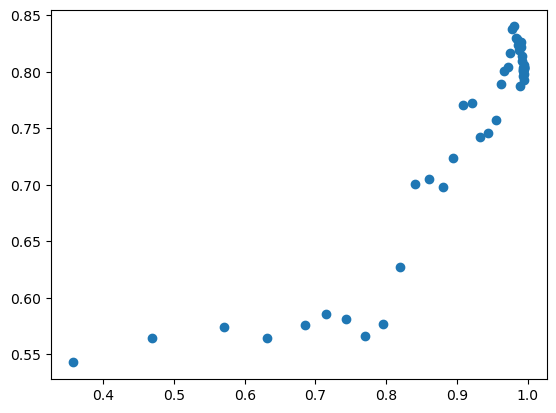

In [339]:
plt.plot(sobolSum,pred,'o')

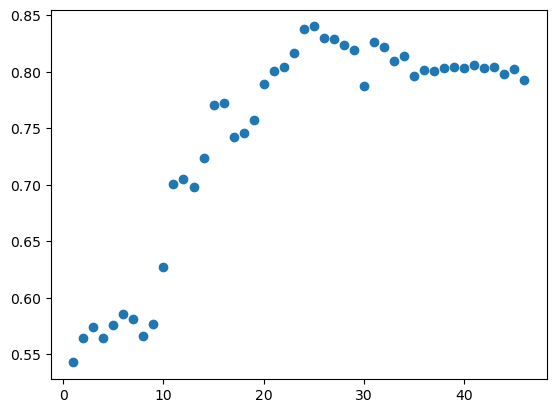

In [340]:
plt.plot(num,pred,'o')

In [368]:
index_lim = 10
x_train_red=x_train[:,ref[0:index_lim]]
x_test_red=x_test[:,ref[0:index_lim]]

In [369]:
emulator = GPE.ensemble(x_train_red,y_train[:,[3]],mean_func="linear",training_iter=1000)

0


In [370]:
emulator.R2(x_test_red,y_test[:,[3]])

tensor([0.6893], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [371]:
boundsMaxMin=np.array(boundsMaxMinOrig)[ref[0:index_lim]]

In [372]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = x_train_red.shape[1]
nwalkers = 2*index_lim
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
#y_val = torch.tensor([80,134])
obs_error=((y_val*0.00005))**2

In [373]:
y_val+2*((y_val*0.05))

tensor([161.7000])

In [374]:
y_val*0.18

tensor([26.4600])

In [375]:
obs_error

tensor([5.4022e-05])

In [376]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error])

sampler.run_mcmc(p0, 20000,progress=True)

100%|████████████████████████████████████| 20000/20000 [02:03<00:00, 161.93it/s]


State([[3.51648517e+00 1.29372778e+02 8.51017908e+02 2.88093396e-01
  1.52777839e-03 2.84531279e-02 4.26045860e+00 4.05682153e-01
  9.42860929e-01 8.27294757e+00]
 [3.23397524e+00 8.11702756e+01 1.78701435e+02 3.53583410e-01
  1.15816783e-03 1.57839227e-02 4.06498357e+00 2.87577730e-01
  6.68434935e-01 1.73107697e+01]
 [3.46938180e+00 6.93249131e+01 3.92101706e+02 1.39389701e-01
  1.72257363e-03 2.32669703e-02 3.87085501e+00 2.91567130e-01
  4.88673671e-01 8.25183337e+00]
 [3.31862925e+00 9.79115783e+01 2.01706662e+02 3.15091477e-01
  2.27070959e-03 1.55461478e-02 2.69942801e+00 4.47843139e-01
  6.84277712e-01 9.31808835e+00]
 [4.81596447e+00 1.24413063e+02 4.70470685e+02 3.52650084e-01
  1.84307702e-03 2.31911133e-02 3.38317952e+00 3.15133769e-01
  6.36850650e-01 1.86153373e+01]
 [2.07704750e+00 1.24383041e+02 1.54221378e+02 2.46528431e-01
  2.35859229e-03 2.87579137e-02 4.34168616e+00 3.24342300e-01
  7.88077146e-01 1.39267082e+01]
 [3.34601990e+00 7.41943006e+01 7.70567121e+02 1.515

In [377]:
flat_samples = sampler.get_chain(discard=2000, thin=100, flat=True)
print(flat_samples.shape)

(3600, 10)


In [378]:
boundsMaxMin

array([[1.19323e-01, 4.99241e+00],
       [5.74508e+01, 1.59391e+02],
       [1.51853e+02, 9.97867e+02],
       [1.25877e-01, 3.57940e-01],
       [9.21633e-04, 2.42766e-03],
       [1.25385e-02, 3.13515e-02],
       [1.52985e+00, 4.46122e+00],
       [1.75616e-01, 4.92279e-01],
       [4.11652e-01, 9.59688e-01],
       [5.21288e-01, 2.39351e+01]])

In [379]:
flat_samples.shape

(3600, 10)

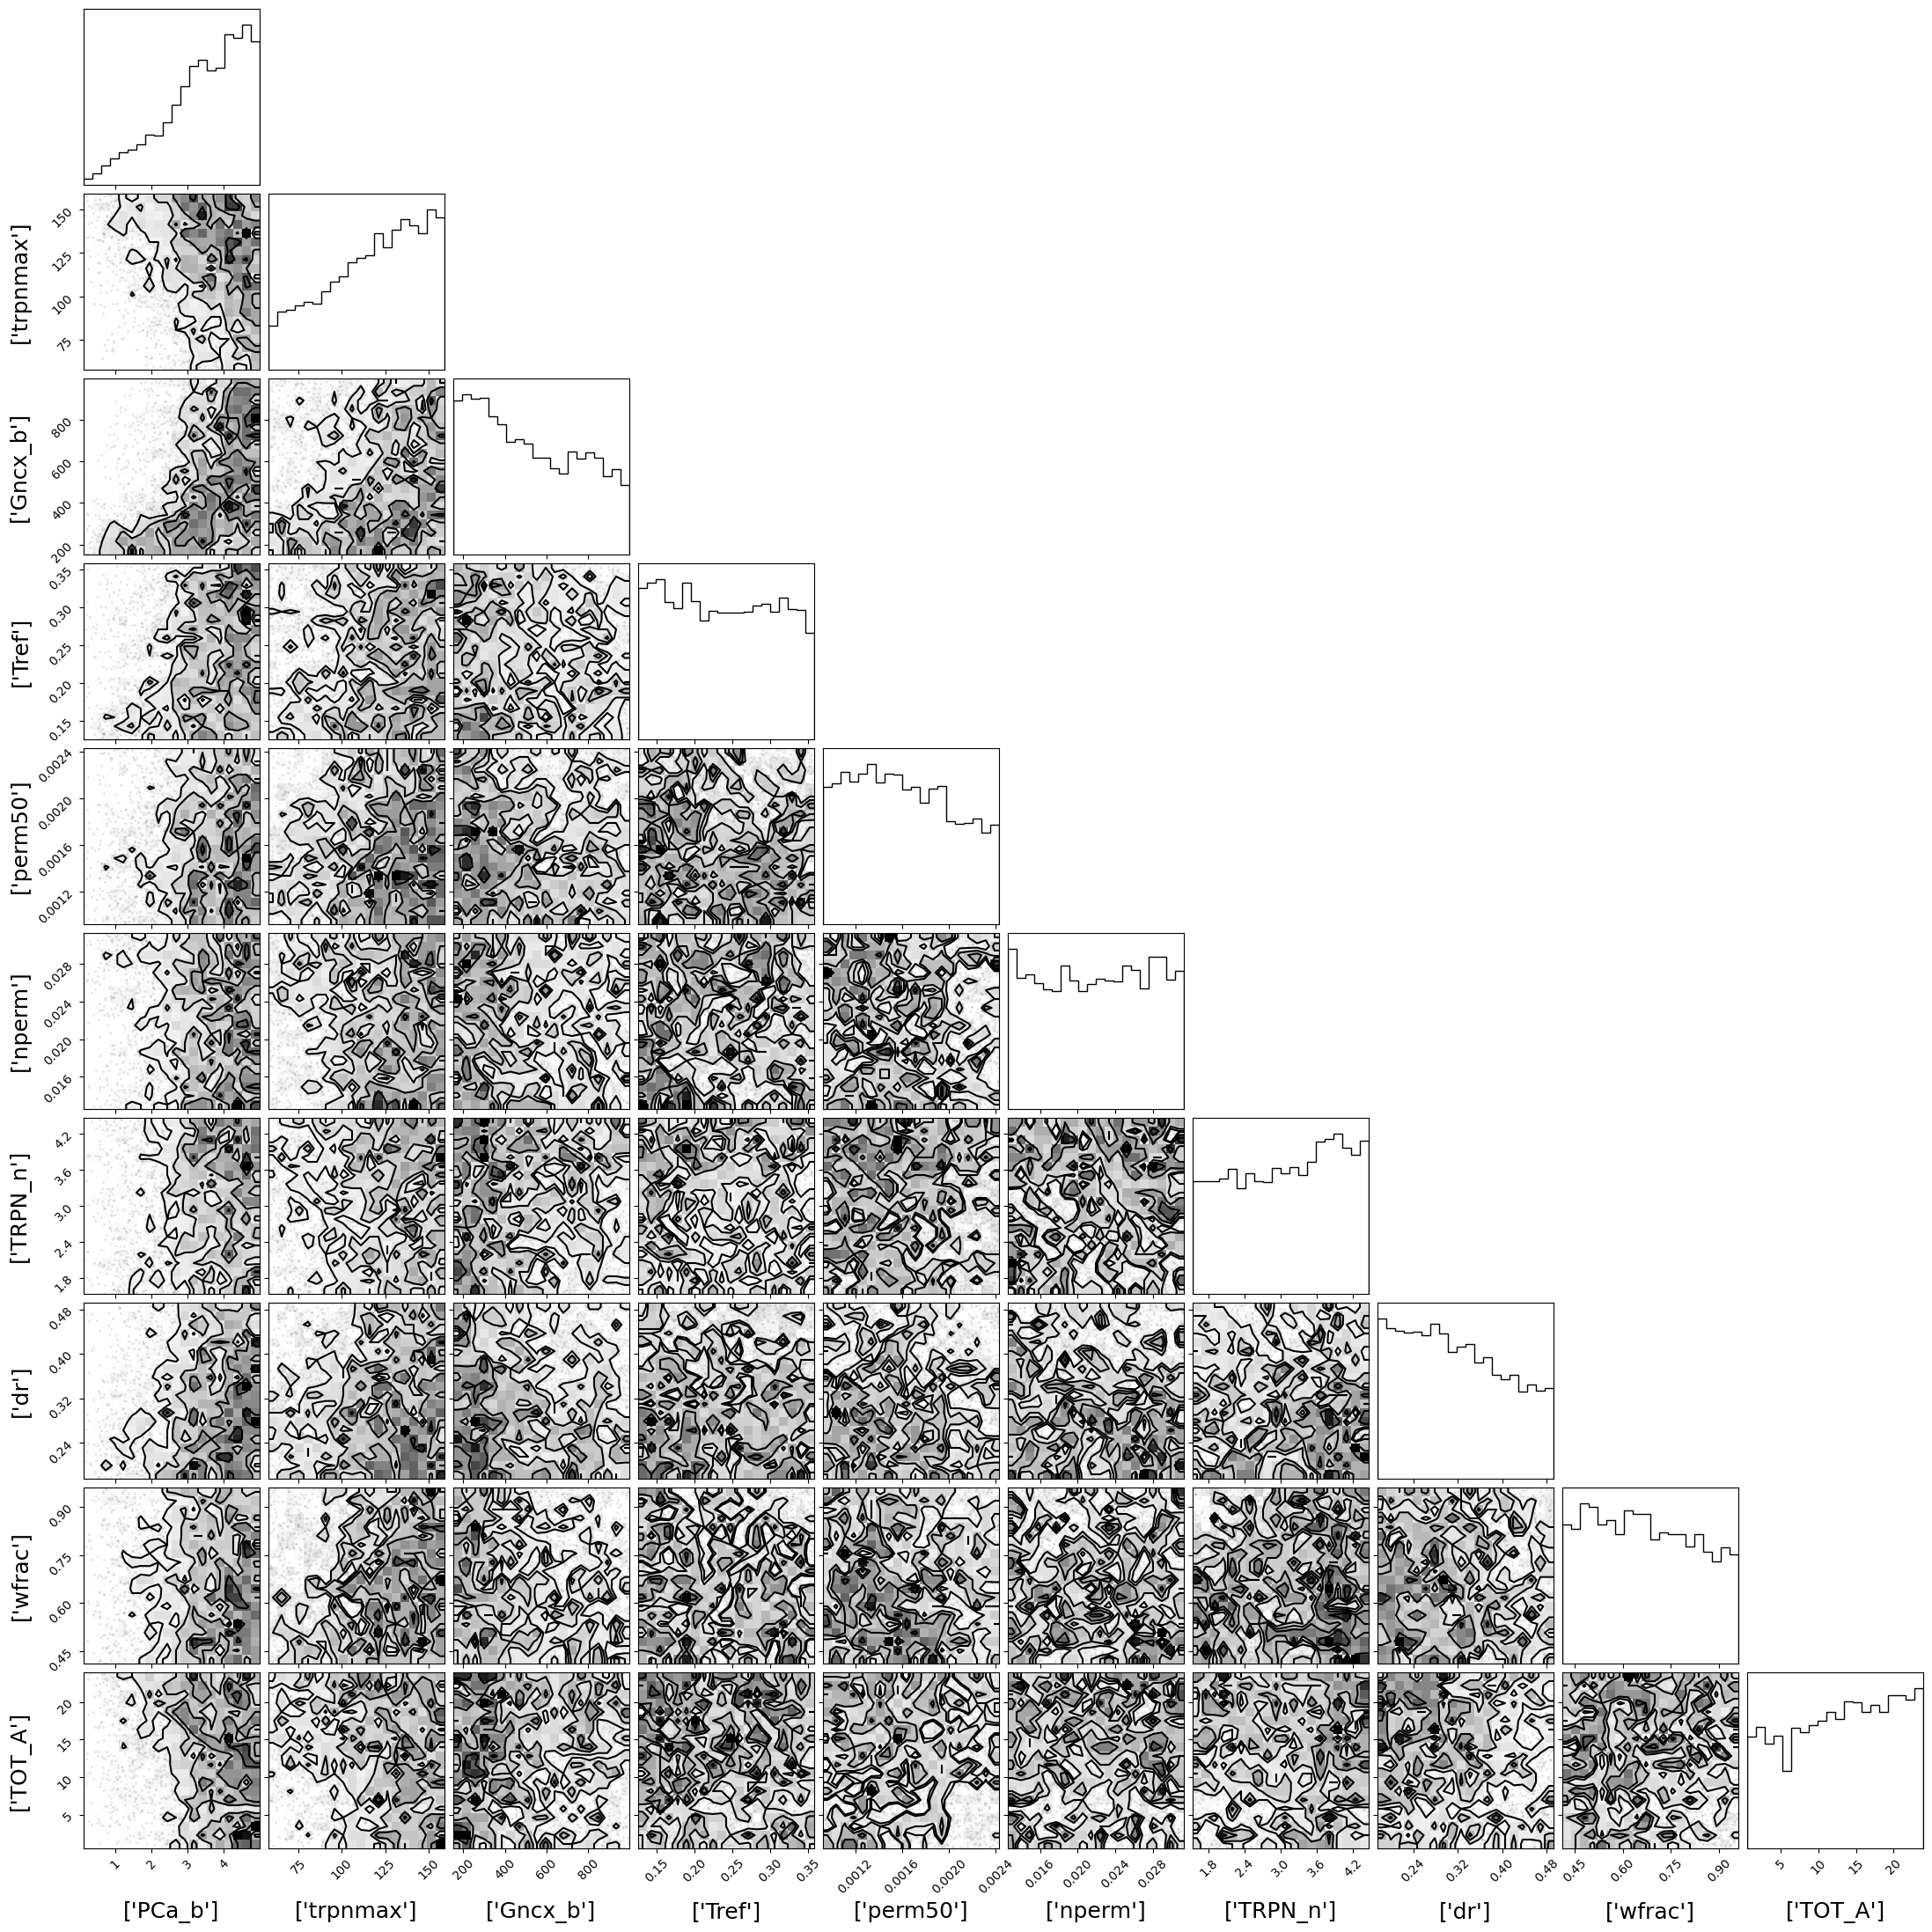

In [380]:
import corner

fig = corner.corner(
    flat_samples[:,:], labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

(array([  7.,  40., 165., 484., 851., 961., 714., 291.,  75.,  12.]),
 array([ 80.68623352,  91.76973724, 102.8532486 , 113.93675232,
        125.02026367, 136.10375977, 147.18727112, 158.27078247,
        169.35429382, 180.43778992, 191.52130127]),
 <BarContainer object of 10 artists>)

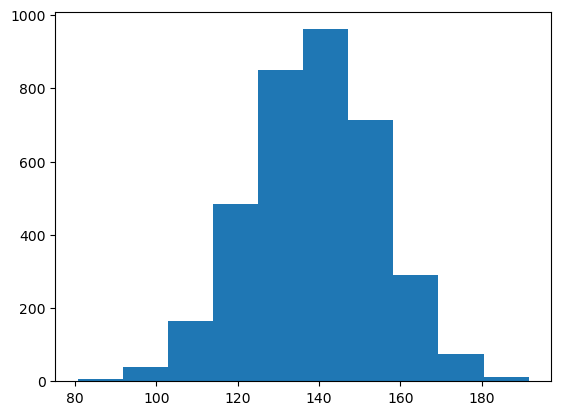

In [381]:
plt.hist(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,0])

In [382]:
emulator.predict(torch.tensor(flat_samples)).mean(axis=0)

tensor([138.6802], grad_fn=<MeanBackward1>)

In [383]:
emulator.predict(torch.tensor(flat_samples)).std(axis=0)

tensor([15.8586], grad_fn=<StdBackward0>)

In [384]:
y_val*0.05

tensor([7.3500])

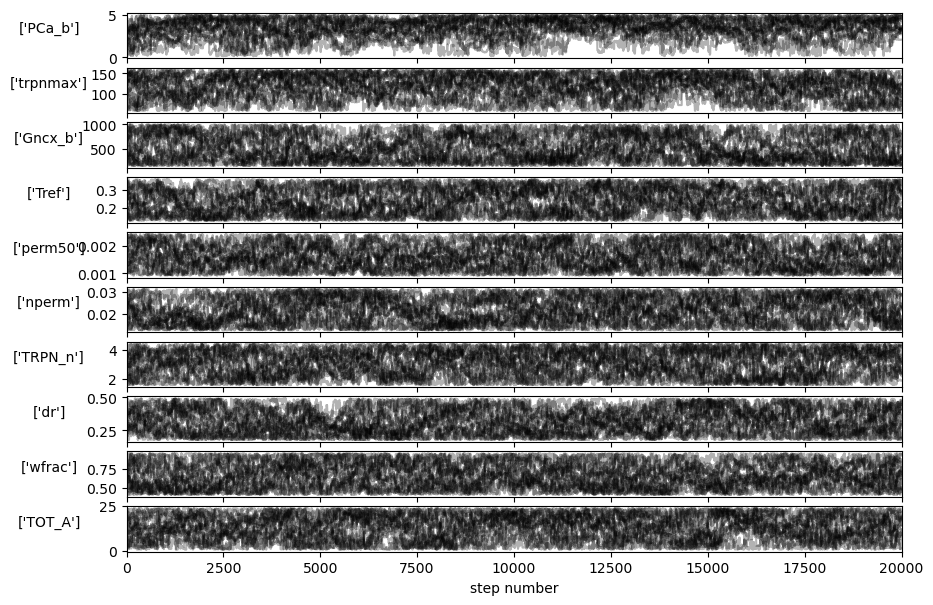

In [385]:
fig, axes = plt.subplots(index_lim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(index_lim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [386]:
y_train[:,3].mean()

tensor(126.6255, dtype=torch.float64)

In [387]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([2.32680321e+00, 9.09286807e+01, 2.74859272e+02, 1.70168742e-01,
       1.19717159e-03, 1.64751420e-02, 2.23543075e+00, 2.28019146e-01,
       5.15863258e-01, 6.36554118e+00])

In [388]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([4.54870075e+00, 1.45740391e+02, 7.63311273e+02, 3.05081053e-01,
       2.03599364e-03, 2.75413649e-02, 3.93859510e+00, 4.05868288e-01,
       8.25646266e-01, 1.98039259e+01])

In [389]:
boundsMaxMin

array([[1.19323e-01, 4.99241e+00],
       [5.74508e+01, 1.59391e+02],
       [1.51853e+02, 9.97867e+02],
       [1.25877e-01, 3.57940e-01],
       [9.21633e-04, 2.42766e-03],
       [1.25385e-02, 3.13515e-02],
       [1.52985e+00, 4.46122e+00],
       [1.75616e-01, 4.92279e-01],
       [4.11652e-01, 9.59688e-01],
       [5.21288e-01, 2.39351e+01]])

In [390]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None])

tensor([[131.4738]], grad_fn=<PermuteBackward0>)

In [391]:
torch.tensor(flat_samples.mean(axis=0))[None]

tensor([[3.4378e+00, 1.1833e+02, 5.1909e+02, 2.3762e-01, 1.6166e-03, 2.2008e-02,
         3.0870e+00, 3.1694e-01, 6.7075e-01, 1.3085e+01]], dtype=torch.float64)